# Notebook to plot orthogonality between stimulus and delay phases.

In [228]:
"""Imports."""

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.decomposition import PCA

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [234]:
"""Load data."""

SUBJECT = "Perle"
# SUBJECT = "Elgar"

_BASE_DATA_DIR = Path("../../../cache/figures/supp_fig_stimulus/orthogonality")
firing_rates_path = _BASE_DATA_DIR / "firing_rates.npy"
firing_rates_identity_path = _BASE_DATA_DIR / "firing_rates_identity.npy"
unit_data_path = _BASE_DATA_DIR / "unit_data.csv"
firing_rates = np.load(firing_rates_path, allow_pickle=True).item()
unit_data = pd.read_csv(unit_data_path)

# Stack data Conditions x Time x Units
firing_rates = np.stack(
    [firing_rates[k] for k in sorted(firing_rates.keys())], axis=0,
)
firing_rates = np.transpose(firing_rates, (0, 2, 1))

# Get index of units from subject
subject_unit_indices = unit_data.index[unit_data["subject"] == SUBJECT].tolist()
firing_rates = firing_rates[:, :, subject_unit_indices]

# Remove units with NaNs
valid_units = ~np.isnan(firing_rates).any(axis=(0, 1))
firing_rates = firing_rates[:, :, valid_units]
n_conditions, n_timepoints, n_units = firing_rates.shape
print(firing_rates.shape)

# Bin to 20 bins
fr_rates_all = np.zeros((n_conditions, 20, n_units))
for i in range(20):
    fr_rates_all[:, i, :] = np.mean(firing_rates[:, 2 * i: 2 * (i + 1), :], axis=1)
firing_rates = fr_rates_all
n_conditions, n_timepoints, n_units = firing_rates.shape
print(firing_rates.shape)
_BIN_MS = 100

(3, 40, 1638)
(3, 20, 1638)


(3, 20, 3)


/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T

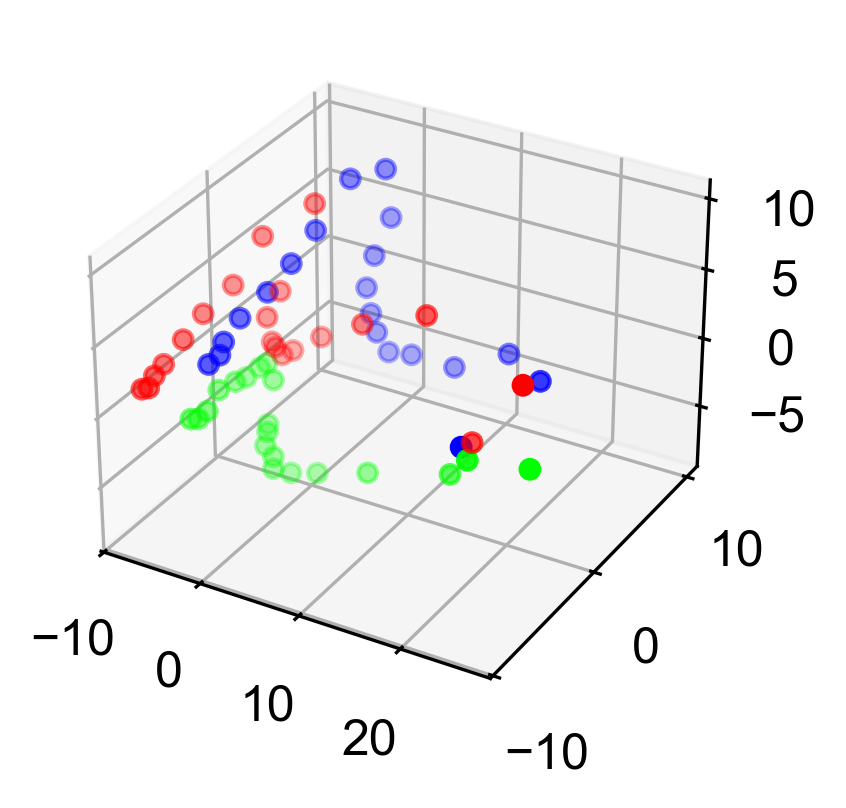

In [235]:
"""Plot PCA on firing rates."""

# PCA reduce the first dimension
n_components = 3
fr_shape = firing_rates.shape
pca = PCA(n_components=n_components)
fr_flat = firing_rates.reshape(-1, n_units)
fr_flat -= fr_flat.mean(axis=-1, keepdims=True)
firing_rates_pca = pca.fit_transform(fr_flat)
firing_rates_pca = firing_rates_pca.reshape(
    n_conditions, n_timepoints, n_components)
print(firing_rates_pca.shape)

# Make 3d plot
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111, projection='3d')
for i in range(3):
    color = [0, 0, 0]
    color[i] = 1
    ax.scatter(
        firing_rates_pca[i, :, 0].flatten(),
        firing_rates_pca[i, :, 1].flatten(),
        firing_rates_pca[i, :, 2].flatten(),
        color=color,
    )


In [236]:
"""Compute spanning subspaces."""

_REFERENCE_TIMEPOINT = 10
_N_BOOTSTRAPS = 10

def _get_cosine_dataframe(fr):
    n_conditions, n_timepoints, _ = fr.shape
    fr_demeaned = fr - fr.mean(axis=0, keepdims=True)

    # Compute angles between subspaces
    reference = fr_demeaned[:, _REFERENCE_TIMEPOINT]

    cos_thetas = np.nan * np.ones((n_conditions, n_timepoints))
    for t in range(n_timepoints):
        target = fr_demeaned[:, t]
        for i in range(3):
            target_i = target[i]
            reference_i = reference[i]
            cos_theta = np.dot(target_i, reference_i) / (
                np.linalg.norm(target_i) * np.linalg.norm(reference_i)
            )
            cos_thetas[i, t] = cos_theta

    # Make dataframe
    dataframe = {
        "Time (ms)": [],
        "cosine": [],
    }
    for i in range(n_conditions):
        for t in range(n_timepoints):
            dataframe["Time (ms)"].append(_BIN_MS * t)
            dataframe["cosine"].append(cos_thetas[i, t])
    dataframe = pd.DataFrame(dataframe)

    return dataframe

# Get neural data
df_neural = _get_cosine_dataframe(firing_rates)

# Get null distribution
df_null_list = []
firing_rates_all_flat = firing_rates.transpose(0, 2, 1).reshape(-1, n_timepoints)
firing_rates_means = np.mean(firing_rates_all_flat, axis=1)
for _ in range(_N_BOOTSTRAPS):
    firing_rates_shuffled = np.nan * np.ones_like(firing_rates)
    for i in range(n_conditions):
        for j in range(n_units):
            # Sample from the top 10 neuron-conditions with most similar means
            mean_fr = np.mean(firing_rates[:, :, j])
            top_indices = np.argsort(
                np.abs(firing_rates_means - np.mean(firing_rates[:, :, j]))
            )[:10]
            flat_index = np.random.choice(top_indices)

            new_fr = firing_rates_all_flat[flat_index]
            if np.mean(new_fr) == 0:
                print('bad')
                new_fr += 1e-6
            firing_rates_shuffled[i, :, j] = mean_fr * new_fr / np.mean(new_fr)
    df_null = _get_cosine_dataframe(firing_rates_shuffled)
    df_null_list.append(df_null)
df_null = pd.concat(df_null_list, ignore_index=True)

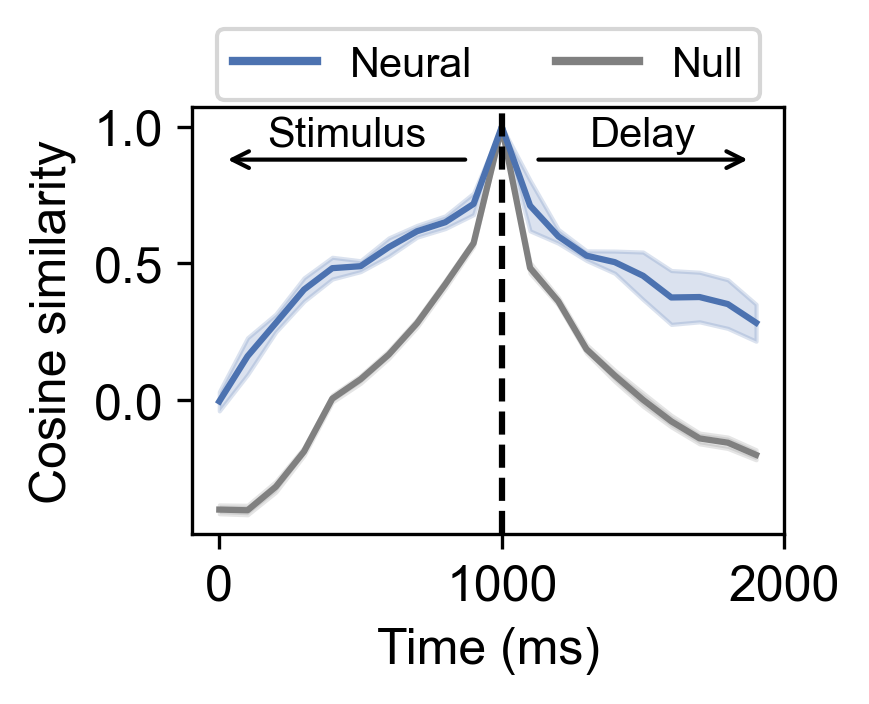

In [237]:
"""Plot."""

# Make plot
fig, ax = plt.subplots(figsize=(3, 2.5))
sns.lineplot(
    data=df_null,
    x="Time (ms)",
    y="cosine",
    color="gray",
    ax=ax,
)
sns.lineplot(
    data=df_neural,
    x="Time (ms)",
    y="cosine",
    ax=ax,
    color=sns.color_palette("deep")[0],
    errorbar="sd",
)
ax.set_xticks([0, 1000, 2000])
ax.set_ylabel("Cosine similarity")

# Make vertical dashed line at time 0 ms
ax.axvline(x=1000, color='k', linestyle='--')

# Make arrow to the left near the top
ax.annotate(
    '', xy=(0, 0.88), xytext=(900, 0.88),
    arrowprops=dict(arrowstyle='->')
)
ax.annotate(
    '', xy=(1100, 0.88), xytext=(1900, 0.88),
    arrowprops=dict(arrowstyle='<-')
)
ax.text(450, 0.9, 'Stimulus', ha='center', va='bottom', fontsize=10)
ax.text(1500, 0.9, 'Delay', ha='center', va='bottom', fontsize=10)

# Make custom legend
custom_lines = [
    Line2D([0], [0], color=sns.color_palette("deep")[0], lw=2, label='Neural'),
    Line2D([0], [0], color='gray', lw=2, label='Null'),
]
ax.legend(
    handles=custom_lines,
    loc='center',
    frameon=True,
    fontsize=10,
    ncol=2,
    bbox_to_anchor=(0.5, 1.1),
)

# Save figure
fig.tight_layout()
fig.savefig(f"./orthogonality_{SUBJECT}.pdf", bbox_inches='tight', pad_inches=0.01)